# Interpolação Paramétrica de Margens Foliares com Splines

**Brisa do Nascimento Barbosa e Mateus Krause Eleoterio**

O presente trabalho visa aplicar um método de interpolação de pontos, obtidos automaticamente por meio de visão computacional, para extrair o contorno de uma folha. Folhas são um dos mais importantes órgãos estruturais e funcionais das plantas, e as modelar computacionalmente é importante para o estudo de diversos problemas, como: Análise morfométrica das plantas; Reconstrução 3D da cobertura formada por copas de árvores; Estimar quantidade de luz que atravessa copas de árvores; Simular distribuição de água e luz nas folhas; Modelar resíduos de pesticidas na superficie foliar; Análise de crescimento e resposta das plantas; Entre outras.

Existem diversas técnicas para a reconstrução de folhas (e plantas como um todo), porém aplicadas à reconstrução 3D para usos como jogos digitais, por exemplo. Embora sejam representações realistas, deixam a desejar no quesito acurácia. Para aplicações que demandam simulações de ambiente, por exemplo, são necessários modelos extremamente precisos, extraídos de fontes reais. A reconstrução 3D da canópia vegetal, por exemplo, é fundamental para a modelagem funcional-estrutural de plantas (Functional-Structural Plant Modeling - FSPM), permitindo simular a distribuição e análise da luz dentro das copas das plantas. A reconstrução superficial de plantas contribui para a compreensão detalhada da arquitetura vegetal, o que é crucial para estudos de ecologia, fisiologia e melhoramento vegetal.

### Escopo

Este documento se motiva do artigo "[A Leaf Modeling and Multi-Scale Remeshing Method for Visual Computation via Hierarchical Parametric Vein and Margin Representation](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00783/full)", em que é aplicado a técnica de reconstrução de superfícies de plantas para a modelagem estrutural funcional delas. A abordagem utilizada pode ser descrita com os seguintes passos:

- Aquisição de dados: Dada uma folha real, técnicas como escaneamento 3D com pré-processamento são utilizadas;
- Extração de características: Selecionar de forma hierárquica pontos importantes que definem o esqueleto da planta, formado por veias e margens, conectando-as com B-Splines;
- Modelagem paramétrica de superfície: Criar uma superfície auxiliar utilizando [NURBS](https://pt.wikipedia.org/wiki/NURBS) definida pelas curvas geradas anteriormente;
- Reamostragem e geração de [malha](https://pt.wikipedia.org/wiki/Malha_poligonal): Pontos importantes são extraídos das curvas e o modelo de superfície, gerando uma malha a partir dessa extração;
- Otimização da malha: Gerar diferentes resoluções para a malha, com o objetivo de equilibrar eficiência computacional e preservação de detalhes.

![img](https://www.frontiersin.org/files/Articles/276320/fpls-09-00783-HTML/image_m/fpls-09-00783-g001.jpg)

Aqui daremos foco às duas primeiras etapas, de uma forma simplificada, com potencial de expansão para futuras pesquisas, incluindo a identificação automática do sistema vascular das folhas, análise ecológica considerando parâmetros como luz, interação funcional com insetos, e características fisiológicas. Nossa abordagem será a seguinte:

- Aquisição de dados: Dada a imagem de uma folha real, aplicaremos algoritmos de visão computacional para extrair pontos-chave das margens;
- Extração de características: Resolveremos o problema de interpolação com uma curva B-Spline periódica (fechada e contínua) com os pontos-chave das margens.

Mesmo simplificado, teremos uma base de estudo para a resolução do problema de modelagem de folhas.

In [2]:
# dependências
import numpy as np
import matplotlib.pyplot as plt

# visão computacional
import cv2
import torch
import requests
from PIL import Image
from io import BytesIO
from scipy.ndimage import gaussian_filter1d
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter1d
from skimage.morphology import skeletonize
from sklearn.cluster import KMeans

# <span style="color:; background-color:OliveDrab;">  Aquisição de Dados </span>

Nesta etapa, teremos como objetivo obter pontos-chave de uma folha baseada na sua imagem. Para isso, serão utilizadas técnicas de visão computacional.

## <span style="color:; background-color:#366e3b;"> Modelo 2D</span>

In [ ]:
url = "DATASET/exemplar_05.JPG"
img = np.array(Image.open(url).convert("RGB"))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

A imagem original está no formato **RGB** (Red, Green, Blue), que é ótimo para exibição em telas, mas nem sempre é o mais eficiente para segmentação.

Para segmentar cores específicas (como o verde da folha), utilizamos o modelo de cores **HSV**:

- *H (Hue / Matiz)*: Representa a **cor** propriamente dita (0 a 180 no OpenCV).
- *S (Saturation / Saturação)*: Representa o quão "viva" é a cor. Cores mais acinzentadas têm saturação baixa.
- *V (Value / Valor)*: Representa o brilho da cor.

O espaço HSV facilita muito a criação de **máscaras baseadas em cor**, pois conseguimos isolar apenas o tom de verde, independentemente da iluminação. Daí, podemos segmentar a cor da folha utilizando intervalos de valores de matiz (Hue), saturação e brilho.

Queremos isolar <span style="color:; background-color:SeaGreen;"> tons de verde</span>, então definimos um intervalo de valores que representam o verde comum:

- Hue: entre 40 e 100 (aproximadamente verde amarelado até verde azulado)
- Saturação e Valor: usamos limites abertos para incluir tons claros e escuros

Usamos `cv2.inRange()` para criar máscara binária (1 onde está verde).  

Depois, aplicamos **operações morfológicas** para limpar ruídos:

- `morphologyEx(..., MORPH_CLOSE)` preenche pequenos buracos na máscara.

In [ ]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

lower_green = np.array([30, 40, 40])
upper_green = np.array([90, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# Aplicar máscara na imagem original
masked_img = cv2.bitwise_and(img, img, mask=mask_clean)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_clean, cmap='gray')
axs[1].set_title("Máscara Segmentada e Limpa")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Identificamos o maior contorno da imagem segmentada, que será usado para análise de curvatura. Também garantimos que o contorno seja fechado. 

Usamos derivadas suavizadas com filtro Gaussiano para calcular a curvatura ao longo do contorno. Isso reduz o ruído e facilita a detecção de pontos significativos.

In [ ]:
# Encontra os contornos externos na máscara e pega o maior contorno
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = max(contours, key=cv2.contourArea).squeeze()
contour_closed = np.vstack([contour, contour[0]])

def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)  # suavização com filtro Gaussiano
    grad = np.gradient(smoothed, axis=0)  # gradiente
    return grad

# Calcula a primeira derivada (dx, dy) dos pontos do contorno suavizado
dx = smooth_derivative(contour_closed[:, 0].astype(float))
dy = smooth_derivative(contour_closed[:, 1].astype(float))

# Calcula a segunda derivada (d²x, d²y)
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

# Calcula a curvatura em cada ponto do contorno usando a fórmula clássica de curvatura 2D
curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature)


Segmentamos o contorno em `num_points` segmentos iguais iguais e, em cada segmento, escolhemos o ponto de maior curvatura local. Isso garante pontos bem distribuídos e relevantes para a forma da borda. Isso garante uma distribuição uniforme e que cada ponto escolhido seja relevante do ponto de vista morfológico.

In [ ]:
def significant_points(img, contour_closed, abs_curvature, num_points=100):
    N = len(contour_closed)
    step = N // num_points

    final_indices = []
    for i in range(num_points):
        start = i * step
        end = (i + 1) * step if i < num_points - 1 else N
        region_indices = range(start, end)
        best_idx = max(region_indices, key=lambda idx: abs_curvature[idx])
        final_indices.append(best_idx)

    final_points = contour_closed[final_indices]

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.plot(contour_closed[:, 0], contour_closed[:, 1], '--', color='gray', lw=1, alpha=0.8)
    plt.scatter(final_points[:, 0], final_points[:, 1], c='red', s=5, marker='o')
    plt.title(f'{num_points} Pontos Distribuídos e Significativos')
    plt.show()

significant_points(img, contour_closed, abs_curvature, num_points=30)

## <span style="color:; background-color:#854a8f;"> Modelo 3D</span>

In [ ]:
url = "DATASET/exemplar_01.JPG"
img = np.array(Image.open(url).convert("RGB"))

plt.figure(figsize=(5, 5))
plt.imshow(img)
plt.title("Imagem Original")
plt.show()

Convertendo a imagem para o espaço de cor HSV e segmentando regiões verdes, como anteriormente.

In [ ]:
# HSV e máscara
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
lower_green = np.array([40, 50, 50])
upper_green = np.array([100, 255, 255])
mask = cv2.inRange(hsv, lower_green, upper_green)

# Limpeza da máscara
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# Aplicar máscara
masked_img = cv2.bitwise_and(img, img, mask=mask_cleaned)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(hsv[:, :, 0], cmap='hsv')
axs[0].set_title("Canal H (Hue)")
axs[1].imshow(mask_cleaned, cmap='gray')
axs[1].set_title("Máscara Segmentada")
axs[2].imshow(masked_img)
axs[2].set_title("Segmentação Aplicada")
plt.tight_layout()
plt.show()

Aplicamos o MiDaS (**M**ulti-**D**epth **A**ware **S**ynthesis), que é um modelo de aprendizado profundo desenvolvido para estimar mapas de profundidade monoculares — isto é, profundidade relativa da cena apenas a partir de uma imagem 2D. Ele gera uma imagem em escala de cinza, onde cada pixel indica a profundidade relativa (quanto menor, mais perto).


In [ ]:


# Carregar modelo MiDaS e transformações
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small")
transforms = torch.hub.load("intel-isl/MiDaS", "transforms").small_transform

# Configurar dispositivo (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device).eval()

# Transformar e enviar imagem para dispositivo
inp = transforms(img).to(device)

with torch.no_grad():
    pred = midas(inp)

# Extrair profundidade e normalizar
depth = pred.squeeze().cpu().numpy()
dmin, dmax = depth.min(), depth.max()
depth_n = (depth - dmin) / (dmax - dmin)

# Visualizar mapa de profundidade normalizado
plt.figure(figsize=(5,5))
plt.imshow(depth_n, cmap='plasma')
plt.title("Mapa de Profundidade Estimado (Normalizado)")
plt.show()


O mapa de profundidade gerado por modelos como o MiDaS tem resolução diferente da imagem original, geralmente menor. Para aplicar a segmentação corretamente também na profundidade, precisamos redimensionar a máscara da folha para o mesmo tamanho do mapa de profundidade.

Para identificar bordas precisas da folha na profundidade, extraímos um "anel" na borda da máscara:

- Erode a máscara para reduzir sua área.
- Subtrai a máscara erodida da original para obter um anel nas bordas.

Caso existam vários anéis, mantemos apenas o maior, que corresponde à borda principal da folha.

Para identificar detalhes importantes na forma e na superfície da folha, aplicamos o detector de bordas Canny

Usamos dois pares de limiares diferentes para ajustar a sensibilidade :
- Na máscara 2D: limiares mais altos (100–200), pois a imagem é limpa
- No mapa de profundidade: limiares mais baixos (50–150), para captar variações suaves

Após detectar as bordas, aplicamos a máscara do anel da borda para filtrar apenas as bordas próximas ao contorno da folha. 

Em seguida, calculamos o gradiente da profundidade na região do anel para detectar onde há mudanças significativas. Ooperador de Sobel, que estima a variação da profundidade nas direções horizontal (grad_x) e vertical (grad_y). A partir desses dois componentes, obtemos a magnitude do gradiente, que representa a intensidade da mudança de relevo em cada ponto da folha.

Enquanto **Canny** detecta bordas bem definidas, **gradientes** capturam:
- *Mudanças gradativas*: Transições suaves mas significativas
- *Intensidade quantitativa*: Não apenas presença, mas magnitude da mudança
- *Sensibilidade ajustável*: Limiar pode ser otimizado para cada aplicação

In [ ]:
# Redimensionar a máscara para o tamanho do mapa de profundidade
h, w = depth_n.shape
mask_down = cv2.resize(mask_cleaned.astype(np.uint8), (w,h), interpolation=cv2.INTER_NEAREST)

# Normalizar máscara para valores entre 0 e 1
mask_f = mask_down.astype(np.float32) / 255.0
# Aplicar máscara no mapa de profundidade
depth_leaf = depth_n * mask_f

# Erosão para criar anel
eroded = cv2.erode(mask_down, np.ones((4,4), np.uint8))

# Anel = máscara original menos erodida
rim = ((mask_down - eroded) > 0).astype(np.uint8)

# Encontrar contornos do anel
contours, _ = cv2.findContours(rim, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if len(contours) > 0:
    # Maior contorno
    largest_contour = max(contours, key=cv2.contourArea)
    rim_largest = np.zeros_like(rim)
    cv2.drawContours(rim_largest, [largest_contour], -1, 1, thickness=cv2.FILLED)

    eroded_largest = cv2.erode(rim_largest, np.ones((7,7), np.uint8))
    rim = ((rim_largest - eroded_largest) > 0).astype(np.uint8)

# Detector Canny na máscara downsized para bordas
edges_mask = cv2.Canny(mask_down, 100, 200)

# Detector Canny no mapa de profundidade para bordas
depth_uint8 = np.uint8(depth_leaf * 255)
edges_depth = cv2.Canny(depth_uint8, 50, 150)

# Filtrar bordas para a região do anel
edges_ring = cv2.bitwise_and(edges_depth, edges_depth, mask=rim.astype(np.uint8))

grad_x = cv2.Sobel(depth_leaf, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(depth_leaf, cv2.CV_64F, 0, 1, ksize=5)
grad_mag = np.sqrt(grad_x**2 + grad_y**2)

th = 0.04
dges = ((grad_mag > th) & (rim > 0))

# Visualização
plt.figure(figsize=(5, 5))
plt.imshow(grad_mag, cmap='inferno')
plt.title("Magnitude do Gradiente")
plt.axis('off')
plt.show()

Assim, rendedizando a superfície 3D da folha com a borda detectada sobreposta, temos algo impreciso.


In [ ]:
ys, xs = np.where(dges)
zs = depth_leaf[ys, xs]

h, w = depth_leaf.shape
X, Y = np.meshgrid(np.arange(w), np.arange(h))
Z = depth_leaf

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.8)
ax.scatter(xs, ys, zs, color='cyan', s=12, label='Borda 3D')
ax.set_title('Folha 3D com Borda Real')
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_zlabel('Profundidade Normalizada')
ax.view_init(elev=45, azim=100)
ax.legend()
plt.show()


Calculamos o esqueleto da borda e extraímos os pontos de maior curvatura como candidatos a vértices da folha.

(A **esqueletonização** transforma uma região binária 2D em um conjunto de linhas 1D que mantém a topologia da forma original. Cada ponto do esqueleto é, por definição, aproximadamente equidistante de duas bordas da forma)

Utilizamos **KMeans** para agrupar os pontos do esqueleto e selecionamos os pontos com maior curvatura em cada cluster.

In [ ]:
skeleton = skeletonize(rim > 0)
ys_sk, xs_sk = np.where(skeleton)
zs_sk = depth_leaf[ys_sk, xs_sk]

# Formar contorno do esqueleto
contour_sk = np.vstack([xs_sk, ys_sk]).T
contour_closed = np.vstack([contour_sk, contour_sk[0]])  # fechar para suavidade

# Função de derivadas suavizadas
def smooth_derivative(signal, sigma=3.0):
    smoothed = gaussian_filter1d(signal, sigma, axis=0)
    grad = np.gradient(smoothed, axis=0)
    return grad

# Derivadas
dx = smooth_derivative(contour_closed[:, 0])
dy = smooth_derivative(contour_closed[:, 1])
d2x = smooth_derivative(dx)
d2y = smooth_derivative(dy)

# Curvatura (absoluta)
curvature = (dx * d2y - dy * d2x) / ((dx**2 + dy**2)**1.5 + 1e-10)
abs_curvature = np.abs(curvature[:-1])  # corresponde à forma de contour_sk


In [ ]:
def significant_points(num_points=20):
    # Usa variáveis do escopo global: contour_sk, abs_curvature, xs_sk, ys_sk, zs_sk, X, Y, Z
    n = min(num_points, len(xs_sk))
    kmeans = KMeans(n_clusters=n, random_state=42).fit(contour_sk)
    labels = kmeans.labels_

    final_indices = []
    for i in range(n):
        cluster_idxs = np.where(labels == i)[0]
        if len(cluster_idxs) == 0:
            continue
        best_idx = cluster_idxs[np.argmax(abs_curvature[cluster_idxs])]
        final_indices.append(best_idx)

    curv_points = contour_sk[final_indices]
    z_curv = zs_sk[final_indices]

    # Plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='plasma', edgecolor='none', alpha=0.3)
    # ax.scatter(xs_sk, ys_sk, zs_sk, color='magenta', s=10, label='Skeleton')
    ax.scatter(curv_points[:, 0], curv_points[:, 1], z_curv, color='green', s=10, label='Pontos Selecionados')
    ax.set_xlabel('X (px)')
    ax.set_ylabel('Y (px)')
    ax.set_zlabel('Profundidade Normalizada')
    ax.view_init(elev=45, azim=1)
    ax.legend()
    plt.show()

    return curv_points, z_curv

curv_points, z_curv = significant_points(num_points=20)

Para conferir se está ok, projetamos os pontos de curvatura extraídos no plano da imagem original.


In [ ]:
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / w
scale_y = h_orig / h

x_img = curv_points[:, 0] * scale_x
y_img = curv_points[:, 1] * scale_y

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.scatter(x_img, y_img, c='lime', s=25, marker='o', label='Pontos de Maior Curvatura')
plt.axis('off')
plt.title("Pontos Projetados na Imagem Original")
plt.legend(loc='lower right')
plt.show()


# <span style="color:; background-color:OliveDrab;">  Interpolação de Pontos </span>

Dados os pontos de interesse da folha, gostaríamos de obter uma forma de representar sua borda de forma paramétrica (isto é, através de um parâmetro que varia em um certo intervalo). Essa abordagem é interessante poins define uma representação contínua, que podemos posteriormente evaluar numa quantidade de pontos necessária para o que gostaríamos de utilizar.

Para isso, utilizaremos B-splines, pois podemos obter representações precisas, que oferecem controle local sobre a curva e que garantem a continuidade entre segmentos.

## <span style="color:; background-color:DarkOrchid;"> B-Splines </span>

Essas curvas são definidas como combinações lineares de funções polinomiais por partes, e possuem três elementos principais:

- Conjunto de pontos de controle
- Grau polinomial
- Vetor de nós

B-Splines não necessariamente passam pelos pontos de controle, apenas as utilizam para definir sua forma.

Seja o vetor de nós $T = \{t_0, t_1, \dots, t_m\}$, onde $T$ é uma sequência não decrescente com $t_i \in [0, 1]$. Agora defina os pontos de controle $P_0, P_1, \dots, P_n$. Defina o grau como $p = m - n - 1$.

Agora defina a função base como:
$$
N_{i,0}(t) =
\begin{cases}
1 \quad \text{se } t_i \leq t \leq t_{i+1} \\
0 \quad \text{caso contrário}
\end{cases}
$$

$$
N_{i,j}(t) = \frac{t-t_i}{t_{i+j} - t_i} N_{i, j-1}(t) + \frac{t_{i+j+1} - t}{t_{i+j+1} - t_{j-1}} N_{i+1, j-1}(t)
$$

Onde $j = 1, 2, \dots, p$. Então a curva definida por
$$
C(t) = \sum_{i=0}^n P_i N_{i,p}(t)
$$
é uma B-spline.


## <span style="color:Orchid; background-color:;"> Interpolação com B-Splines </span>
Suponha que haja $ n+1 $ pontos $D_0, D_1, \dots, D_n$. Queremos encontrar uma B-spline de grau $p$, onde $p \leq n$, definida por $n+1$ pontos de controle que passa por todos pos pontos na ordem que são definidos.

Esta B-spline possui $n+1$ pontos de controle desconhecidos. Já que o parâmetro $t_k$ corresponde ao ponto $D_k$, utilizando $t_k$ na equação $C(t)$ de uma B-spline, teremos o seguinte:
$$
D_k = C(t_k) = \sum_{i=0}^n N_{i, p}(t_k) P_i \quad 0 \leq k \leq n
$$

Podemos organizar os valores $N_{i, p}(t_k)$ em uma matriz $N$ de dimensões $(n+1) \times (n+1)$ onde a linha $k$ contém os valores $N_{0,p}(u), N_{1,p}(u), \dots, N_{i,p}(u)$ evaluados em $t_k$:
$$
\mathbf{N} =
\begin{bmatrix}
N_{0,p}(t_0) & N_{1,p}(t_0) & N_{2,p}(t_0) & \cdots & N_{n,p}(t_0) \\
N_{0,p}(t_1) & N_{1,p}(t_1) & N_{2,p}(t_1) & \cdots & N_{n,p}(t_1) \\
\vdots       & \vdots       & \vdots       & \ddots & \vdots       \\
N_{0,p}(t_n) & N_{1,p}(t_n) & N_{2,p}(t_n) & \cdots & N_{n,p}(t_n)
\end{bmatrix}
$$

Vamos também representar os vetores $D_k$ e $P_i$ em matrizes $D$ e $P$, onde $D_k$ é um vetor no espaço de dimensão $s$ e que aparece na linha $k$ da matriz $D$. De forma similar, $P_i$ é um vetor no espaço de dimensão $s$ que aparece na linha $i$ da matriz $P$. A dimensão $s$ é a dimensão onde a spline está sendo evaluada. Temos:
$$
\mathbf{D} =
\begin{bmatrix}
d_{01} & d_{02} & d_{03} & \cdots & d_{0s} \\
d_{11} & d_{12} & d_{13} & \cdots & d_{1s} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
d_{n1} & d_{n2} & d_{n3} & \cdots & d_{ns}
\end{bmatrix}
\qquad
\mathbf{P} =
\begin{bmatrix}
p_{01} & p_{02} & p_{03} & \cdots & p_{0s} \\
p_{11} & p_{12} & p_{13} & \cdots & p_{1s} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
p_{n1} & p_{n2} & p_{n3} & \cdots & p_{ns}
\end{bmatrix}
$$

Dessa forma, podemos verificar que podemos representar o problema de intepolação com a seguinte equação:
$$ D = N \cdot P$$

Como a matriz $D$ contém os pontos de entrada e a matriz $N$ é obtida evaluando as funções bases da B-spline nos parâmetros dados, tanto $D$ quanto $N$ são conhecidas, e a única matriz desconhecida é $P$. Se solucionarmos a equação para $P$, obteremos os pontos de controle da B-spline que interpola os pontos, consequentemente obtendo a curva desejada.

### <span style="color:Orchid; background-color:;">  Resolvendo D = NP </span>

Resolveremos a equação coluna por coluna, obtendo assim um sistema linear. Sendo $d^i$ a i-ésima coluna de $D$, e $p^i$ a i-ésina coluna de $P$, teremos o seguinte sistema:
$$ d^i = N \cdot p^i$$

A matriz $N$ é calculada utilizando a função base da B-spline, utilizando o conjunto $T$ de nós (não confundir com o parâmetro de interpolação $t_k$). Esses nós são calculados de diversas formas, que serão omitidas, porém uma explicação mais detalhada pode ser encontrada [aqui](https://pages.mtu.edu/~shene/COURSES/cs3621/NOTES/INT-APP/PARA-knot-generation.html).

Resolvendo para $p^i$, teremos a i-ésima coluna de $P$. Fazendo isso para cada coluna, teremos a matriz $P$ completa e todos os pontos de controle serão computados.

### <span style="color:Orchid; background-color:;"> Obtendo uma B-spline fechada e contínua </span>


No caso de uma B-spline fechada e contínua (ou seja, periódica), o sistema linear muda porque precisamos garantir que a curva passe por todos os pontos dados, seja suave e feche perfeitamente (o início e fim coincidem e suas derivadas também). Para isso, repetiremos o ponto inicial no fim do vetor de pontos, para garantir que a curva seja fechada, e modificaremos o algoritmo que calcula os nós, para que garanta a continuidade necessária.

Por conta disso, a matriz tem um formato de banda cíclica, isto é, tem valores diferentes de zero apenas nas extremidades e em um número fixo de diagonais próximas a diagonal principal. Um exemplo é a matriz $E$ de dimensão $6 \times 6$ a seguir:
$$
E = 
\begin{bmatrix}
* & * & 0 & 0 & 0 & * \\
* & * & * & 0 & 0 & 0 \\
0 & * & * & * & 0 & 0 \\
0 & 0 & * & * & * & 0 \\
0 & 0 & 0 & * & * & * \\
* & 0 & 0 & 0 & * & * \\
\end{bmatrix}
$$

In [ ]:
# importar o método que retorna uma B-spline que resolve o problema de interpolação periódica
from periodic_bspline import make_interp_spline

In [ ]:
def closed_bspline_through_points(points, num_points=200):
    """
    Dados n pontos 2D, retorna uma curva B-spline fechada passando por todos os pontos.
    """
    points = np.asarray(points)
    points = np.vstack([points, points[0]])     # fecha a curva repetindo o primeiro ponto no fim

    n = len(points)

    # parametriza os pontos uniformemente no intervalo [0, 1]
    t = np.linspace(0, 1, n)

    # interpola os pontos separadamente
    spl_x = make_interp_spline(t, points[:, 0], show_linear_system = True)
    spl_y = make_interp_spline(t, points[:, 1], show_linear_system = True)

    t_dense = np.linspace(0, 1, num_points)
    x_dense = spl_x(t_dense)
    y_dense = spl_y(t_dense)

    return x_dense, y_dense

# pontos de exemplo
points = np.array([
    [0, 0],
    [0, 2],
    [3, 1],
    [1, 1],
    [2, 0]
])

# criar e obter pontos da curva
x, y = closed_bspline_through_points(points)

# plotar os pontos e a curva
plt.figure(figsize=(6, 6))
plt.plot(x, y, label='Closed B-spline')
plt.plot(points[:, 0], points[:, 1], 'ro', label='Given Points')
plt.axis('equal')
plt.legend()
plt.title('Closed B-spline Curve Through Given Points')
plt.show()

# Algoritmo para resolução de sistemas lineares de banda cíclica

Na construção de splines periódicos, particularmente B-splines de grau $k$, o sistema linear resultante apresenta uma matriz de coeficientes originalmente banda, com largura $2b + 1$ (onde $b = \lfloor k/2 \rfloor$). Contudo, as condições de periodicidade introduzem termos adicionais que conectam as extremidades da matriz, modificando especificamente os cantos de $A$: os blocos superior-direito e inferior-esquerdo, originalmente nulos, passam a conter valores não-nulos, que garantem a continuidade periódica. Essas modificações afetam apenas $r = k - 1$ linhas e colunas, caracterizando uma correção de baixo posto.

Assim, a matriz total pode então ser escrita como: $\tilde{A} = A + U V^T$, onde
- $A \in \mathbb{R}^{n \times n}$: matriz banda de largura $2b + 1$, com $b = \lfloor k/2 \rfloor$;
- $U, V \in \mathbb{R}^{n \times r}$: matrizes que representam a modificação periódica localizada nos cantos, com $r = k - 1$;
- $U V^T$: termo de correção de baixa patente (low-rank), responsável por conectar as extremidades da matriz e garantir a periodicidade.

Resolver diretamente o sistema linear $\tilde{A} x = b$ seria computacionalmente custoso, pois $\tilde{A}$ perde a estrutura esparsa de $A$ e se torna densa. Enquanto sistemas com matrizes banda podem ser resolvidos eficientemente em $O(n w^2)$ (onde $w \approx k$ é a largura de banda), métodos diretos para matrizes densas exigem $O(n^3)$ operações. No caso de B-splines, onde $w \approx k$, a estrutura banda permite eficiência, mas a adição do termo $U V^T$ destrói essa esparsidade.

No entanto, felizmente, a estrutura específica de $\tilde{A}$, isto é, uma matriz banda mais uma correção de baixo posto, permite utilizar a [fórmula de Sherman-Morrison](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) para resolver o sistema de forma eficiente, evitando a inversão direta de $\tilde{A}$ e mantendo o custo computacional controlado, próximo de $O(n w^2)$.

### <span style="color:Orchid; background-color:;"> Método de Woodbury </span>

O algoritmo de Woodbury é uma aplicação prática da identidade de Woodbury, que por sua vez é a forma matricial em blocos da fórmula de Sherman–Morrison. Essa identidade generaliza a inversão de uma matriz que foi perturbada por um termo low-rank.

Ela permite inverter matrizes densas da forma $A + UCV^T$, onde 
- $A \in \mathbb{R}^{n \times n}$ é uma matriz invertível (geralmente esparsa ou com estrutura de banda),

- $U \in \mathbb{R}^{n \times r}$ e $V \in \mathbb{R}^{n \times r}$ são matrizes que definem a correção de baixo posto,

- $C \in \mathbb{R}^{r \times r}$ é uma matriz pequena, também invertível,

- $r \ll n$, ou seja, a correção tem posto muito menor do que a dimensão do sistema.

A fórmula estabelece que $ (A + UCV^T)^{-1} = A^{-1} - A^{-1}U(C^{-1} + V^T A^{-1} U)^{-1} V^T A^{-1} $

A vatange é que se  $A$ é fácil de inverter (por ser esparsa, diagonal ou, no nosso caso, banda), a fórmula evita a inversão direta da matriz densa. Ainda, $UV^T$ tem posto pequeno, e o cálculo de $\left(I + V^T A^{-1} U\right)^{-1}$ envolve apenas uma matriz pequena de dimensão $r \times r$.


A ideia do algoritmo consiste em quatro passos principais: (1) resolver sistemas banda para pré-condicionar a correção, (2) computar uma pequena matriz de ajuste, (3) resolver o sistema banda original e (4) combinar os resultados para obter a solução final. 

<span style="color:; background-color:MediumOrchid;"> **Passo 1:</span> Resolver sistemas lineares banda $AZ = U$**.
- Para cada coluna $u_i$ da matriz $U \in \mathbb{R}^{n \times r}$, resolve-se o sistema linear banda: $Az_i = u_i $
- Os vetores solução $z_i$ formam as colunas da matriz $Z \in \mathbb{R}^{n \times r}$. Como $A$ é banda, esta operação é computacionalmente eficiente ($\mathcal{O}(n)$ para larguras de banda fixas).

<span style="color:; background-color:MediumOrchid;">**Passo 2:</span> Calcular a matriz de correção $H = (I + V^TZ)^{-1}$**
<br> Calcula-se:
- O produto $V^TZ \in \mathbb{R}^{r \times r}$ (custo $\mathcal{O}(n r^2)$)
- Soma com a identidade: $I + V^TZ$
- Inversão desta matriz pequena: $H = (I + V^TZ)^{-1}$ (custo $\mathcal{O}(r^3)$)

<span style="color:; background-color:MediumOrchid;">**Passo 3:</span> Resolver o sistema banda $Ay = b$**
- Resolve-se o sistema linear original (ignorando a correção): $Ay=b$
- Esta solução $y$ seria exata se $UV^T = 0$.

<span style="color:; background-color:MediumOrchid;">**Passo 4:</span> Calcular a solução final $c = y - ZH(V^Ty)$**
<br> Calcula-se:
- A projeção $V^Ty \in \mathbb{R}^r$ (custo $\mathcal{O}(n r)$)
- Aplica-se a correção: $H(V^Ty)$
- Espalha-se a correção: $ZH(V^Ty) \in \mathbb{R}^n$
- Obtém-se a solução final: $c = y - ZH(V^Ty)$

O vetor $c$ é a solução exata do sistema $(A + UV^T)c = b$.


In [4]:
from scipy.linalg import solve_banded, solve

def woodbury_algorithm(A, ur, ll, b, k):
    '''
    Obtem a solução de um sistema linear banda cíclico com blocos superiores à direita
    e inferiores à esquerda de tamanho ``(k-1) / 2`` usando
    a fórmula de Woodbury

    Parâmetros
    ----------
    A : array 2-D, shape(k, n)
        Matriz das diagonais da matriz original (ver
        documentação de ``solve_banded``).
    ur : array 2-D, shape(bs, bs)
        Bloco superior direito da matriz.
    ll : array 2-D, shape(bs, bs)
        Bloco inferior esquerdo da matriz.
    b : array 1-D, shape(n,)
        Vetor dos termos constantes do sistema de equações lineares.
    k : int
        Grau da B-spline.

    Retorno
    -------
    c : array 1-D, shape(n,)
        Solução do sistema original de equações lineares.
    '''
    k_mod = k - k % 2
    bs = int((k - 1) / 2) + (k + 1) % 2

    n = A.shape[1] + 1
    U = np.zeros((n - 1, k_mod))
    VT = np.zeros((k_mod, n - 1))  # V transposta

    # bloco superior direito
    U[:bs, :bs] = ur
    VT[np.arange(bs), np.arange(bs) - bs] = 1

    # bloco inferior esquerdo
    U[-bs:, -bs:] = ll
    VT[np.arange(bs) - bs, np.arange(bs)] = 1

    Z = solve_banded((bs, bs), A, U)

    H = solve(np.identity(k_mod) + VT @ Z, np.identity(k_mod))

    y = solve_banded((bs, bs), A, b)
    c = y - Z @ (H @ (VT @ y))

    return c

#### <span style="color:Orchid; background-color:;"> Estabilidade e Complexidade </span>

A complexidade computacional do algoritmo é $O(nw² + r³)$, onde:

- $O(nw^2)$ vem da resolução dos sistemas com a matriz banda $A$. Essa matriz possui largura de banda $w$ (número de diagonais não nulas), o que permite *<span style="color:LightSeaGreen; background-color:;"> eliminação gaussiana adaptada<span>* *. Cada operação elementar nessa eliminação envolve $O(w^2)$ operações (pois lida apenas com blocos pequenos), repetidas $n$ vezes (número de equações do sistema), mantendo-se $w$ fixo. Como $w \ll n$, o custo é linear em $n$.

- $O(r^3)$ corresponde à inversão da matriz densa $r \times r$, $(I + V^\top A^{-1} U)$, onde $r = \text{rank}(UV^\top) = k - 1$. Como essa matriz é densa, mas de baixa dimensão, e $k$ (grau do B-spline) é pequeno na prática (tipicamente $k = 3$ ou $5$ para splines cúbicos ou quinticos), esse custo é computacionalmente desprezível em relação ao termo dominante.

Além da eficiência, o método é numericamente estável: a inversão de A (bem-condicionada por ser banda) domina o processo, enquanto a correção de posto baixo $UVᵀ$ introduz mínima perturbação, preservando a precisão.

#### * <span style="color:LightSeaGreen; background-color:;"> Eliminação Gaussiana Adaptada para Matrizes Banda<span>*

m um sistema linear geral $Ax = b$, onde $A \in \mathbb{R}^{n \times n}$, a eliminação gaussiana clássica requer $O(n^3)$ operações para resolver o sistema — isso ocorre porque cada etapa pode envolver combinações de linhas completas, afetando a matriz inteira.

Porém, quando $A$ é uma matriz banda, com largura de banda total $w = l + u + 1$ (sendo $l$ o número de subdiagonais e $u$ o número de superdiagonais), a situação muda drasticamente. A matriz banda tem uma forma onde a maior parte da matriz é composta de zeros, exceto por uma faixa diagonal de largura $w$.

$A = \begin{pmatrix}
a_{11} & a_{12} & \cdots & a_{1,u+1} & 0 & \cdots & 0 \\
a_{21} & a_{22} & \cdots & a_{2,u+2} & \ddots & \ddots & \vdots \\
\vdots & \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & a_{n,n-l} & \cdots & \cdots & \cdots & a_{nn}
\end{pmatrix}$

Durante a eliminação gaussiana, cada pivô $a_{ii}$ afeta apenas as próximas $l$ linhas e $u$ colunas. Como consequência, cada etapa da eliminação envolve apenas $O(w^2)$ operações (em vez de $O(n^2)$), e como há $n$ pivôs, o custo total é $O(nw^2)$ 


# <span style="color:; background-color:OliveDrab;">  Representando Folhas </span>

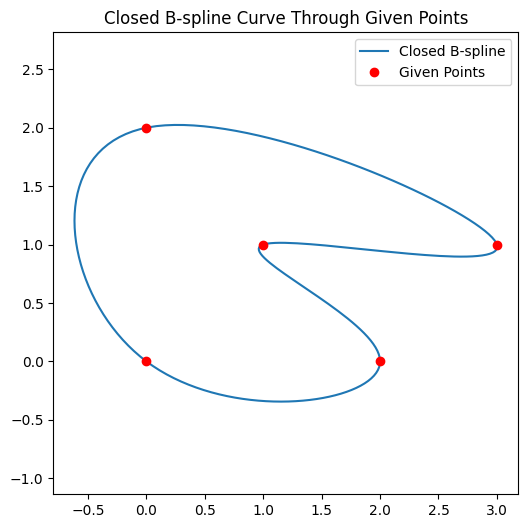

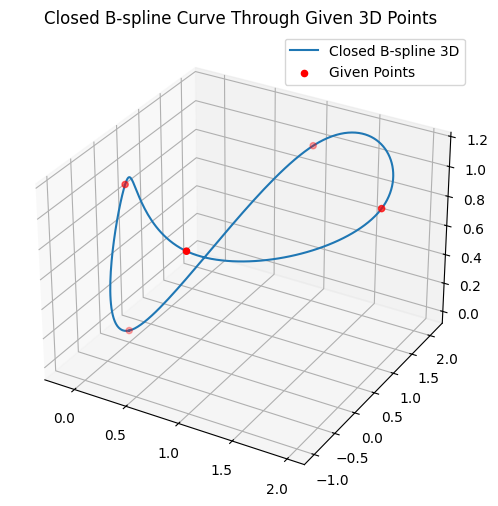

In [ ]:
from periodic_bspline import make_interp_spline

def closed_bspline_through_points(points, num_points=200):
    """
    dados n pontos 2D ou 3D, retorna uma curva B-spline fechada passando por todos os pontos.
    """
    points = np.asarray(points)
    if points.shape[1] not in (2, 3):
        raise ValueError("insira pontos 2D ou 3D apenas")

    points = np.vstack([points, points[0]])  # fecha a curva repetindo o primeiro ponto no fim
    n = len(points)
    t = np.linspace(0, 1, n)

    # interpola cada dimensão separadamente
    splines = []
    for dim in range(points.shape[1]):
        spl = make_interp_spline(t, points[:, dim], wa=woodbury_algorithm)
        splines.append(spl)

    t_dense = np.linspace(0, 1, num_points)
    coords = [spl(t_dense) for spl in splines]
    result = np.stack(coords, axis=-1)

    return result if points.shape[1] == 3 else (coords[0], coords[1])

# pontos de exemplo
points = np.array([
    [0, 0],
    [0, 2],
    [3, 1],
    [1, 1],
    [2, 0]
])

# criar e obter pontos da curva
x, y = closed_bspline_through_points(points)

# plotar os pontos e a curva
plt.figure(figsize=(6, 6))
plt.plot(x, y, label='Closed B-spline')
plt.plot(points[:, 0], points[:, 1], 'ro', label='Given Points')
plt.axis('equal')
plt.legend()
plt.title('Closed B-spline Curve Through Given Points')
plt.show()

# Exemplo 3D: curva fechada passando por pontos no espaço
points3d = np.array([
    [0, 0, 0],
    [1, 2, 1],
    [2, 1, 1],
    [1, -1, 1],
    [0, 0, 1]
])

curve3d = closed_bspline_through_points(points3d, num_points=200)

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(curve3d[:, 0], curve3d[:, 1], curve3d[:, 2], label='Closed B-spline 3D')
ax.scatter(points3d[:, 0], points3d[:, 1], points3d[:, 2], color='red', label='Given Points')
ax.set_title('Closed B-spline Curve Through Given 3D Points')
ax.legend()
plt.show()
